<a href="https://colab.research.google.com/github/psa2001/computer_vision/blob/main/bird_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd

/root


In [ ]:
cd ..

/


In [ ]:
import os
from pathlib import Path

In [ ]:
#dataset_dir = Path('content/drive/My Drive/bird_segmentation')
#os.chdir(dataset_dir)   

In [ ]:
!unzip 'content/drive/My Drive/bird_segmentation/public_tests.zip' -d public_tests


In [ ]:
ls

bin/      dev/   lib32/  opt/           run/    sys/                usr/
boot/     etc/   lib64/  proc/          sbin/   tensorflow-1.15.2/  var/
content/  home/  media/  public_tests/  srv/    tmp/
datalab/  lib/   mnt/    root/          swift/  tools/


In [ ]:
cd ..

/


##Data

In [ ]:
from os.path import join
from skimage.io import imread
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
from PIL import Image
from skimage.transform import resize
from PIL import Image


def get_data(img_dir_whole, gt_dir_whole):
  set_of_images = []
  set_of_gt = []

  for one_class in tqdm(sorted(os.listdir(img_dir_whole))):
    cur_dir_one_class = join(img_dir_whole, one_class)
    cur_gt_one_class = join(gt_dir_whole, one_class)

    for cur_png in (sorted(os.listdir(cur_dir_one_class))):
      cur_dir_one_bird = join(cur_dir_one_class, cur_png)
      cur_gt_one_bird = join(cur_gt_one_class, cur_png[:-3] + "png")
      
      image = resize(imread(cur_dir_one_bird).astype('float32'), (128, 128, 3)) /255.
      gt = resize(imread(cur_gt_one_bird).astype('float32'), (128,128, 1)) / 255.

      set_of_images.append(image)
      set_of_gt.append(gt)
  return (set_of_images), (set_of_gt)

In [ ]:
img_dir_whole = 'public_tests/00_test_val_input/train/images'
gt_dir_whole = 'public_tests/00_test_val_input/train/gt'

x, y = get_data(img_dir_whole, gt_dir_whole)

100%|██████████| 200/200 [04:23<00:00,  1.32s/it]


In [ ]:
x = np.array(x)
y = np.array(y)
x.shape, y.shape

((8382, 128, 128, 3), (8382, 128, 128, 1))

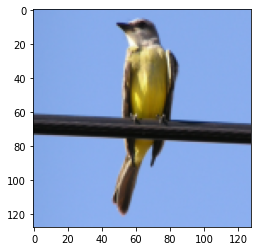

In [ ]:
import matplotlib.pyplot as plt
i = np.random.randint(8382)
plt.imshow(x[i])


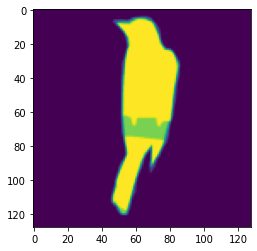

In [ ]:
plt.imshow(y[i,:,:,0])

valid_load

In [ ]:
img_dir_whole = 'public_tests/00_test_val_input/test/images'
gt_dir_whole = 'public_tests/00_test_val_gt'

x_val, y_val = get_data(img_dir_whole, gt_dir_whole)
x_val = np.array(x_val)
y_val = np.array(y_val)

100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


In [ ]:
x_val.shape, y_val.shape

((1406, 128, 128, 3), (1406, 128, 128, 1))

In [ ]:
import matplotlib.pyplot as plt
#plt.imshow(x_val[i], 1)


#Аугментацию проверяем


In [ ]:
"""
angle = np.random.randint(0, 45)
angle_rad = np.radians(45)
i = np.random.randint(x_val.shape[0])
a = skimage.transform.rotate(x_val[i], angle)
b = skimage.transform.rotate(y_val[i], angle)
"""

'\nangle = np.random.randint(0, 45)\nangle_rad = np.radians(45)\ni = np.random.randint(x_val.shape[0])\na = skimage.transform.rotate(x_val[i], angle)\nb = skimage.transform.rotate(y_val[i], angle)\n'

In [ ]:
#plt.imshow(a)


In [ ]:
#plt.imshow(b[:,:,0])


#Prepare_data(easy)

In [ ]:
bird_area = y > 0.5
no_bird = y <= 0.5

bird_area_val = y_val > 0.5
no_bird_val = y_val <= 0.5

In [ ]:
answ_for_fit_train = np.concatenate((no_bird, bird_area),axis = 3)
answ_for_fit_val = np.concatenate((no_bird_val, bird_area_val),axis = 3)

#Architecture + dice_loss + compile


In [ ]:
import tensorflow as tf

model_mobilenet = tf.keras.applications.MobileNet(input_shape=(160, 160, 3), include_top=False, weights="imagenet")

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
#model_mobilenet.summary()
#conv_pw_1_relu
#conv_pw_2_relu 
#conv_pw_3_relu 
#conv_pw_4_relu 
#conv_pw_5_relu 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Conv2DTranspose, Reshape, Input
from tensorflow.keras.models import Model

def get_model():


  model_mobilenet = tf.keras.applications.MobileNet(input_shape=(128, 128, 3), alpha = 1, include_top=False, weights="imagenet")
  #model_mobilenet.trainable = False

  block0 = model_mobilenet.get_layer("conv_pw_1_relu").output 
  block = model_mobilenet.get_layer("conv_pw_1_relu").output
  block1 = model_mobilenet.get_layer("conv_pw_3_relu").output
  block2 = model_mobilenet.get_layer("conv_pw_5_relu").output
  block3 = model_mobilenet.get_layer("conv_pw_11_relu").output
  block4 = model_mobilenet.get_layer("conv_pw_13_relu").output

  x = Concatenate()([UpSampling2D()(block4), block3])
  x = Conv2D(512, kernel_size=1, activation="relu")(x)
  x = Concatenate()([UpSampling2D()(x), block2])
  x = Conv2D(256, kernel_size=1, activation="relu")(x)
  x = Concatenate()([UpSampling2D()(x), block1])
  x = Conv2D(128, kernel_size=1, activation="relu")(x)
  x = Concatenate()([UpSampling2D()(x), block])
  x = Conv2D(64, kernel_size=1, activation="relu")(x)
  #   x = Concatenate()([UpSampling2D()(x), block0])
  x = UpSampling2D()(x)
  x = Conv2D(32, kernel_size=1, activation="relu")(x)
  x = Conv2D(2, kernel_size=1, activation="softmax")(x)


  #model_main = Model(model_mobilenet.input, x)

  model = Model(
        inputs=model_mobilenet.input,
        outputs=x
    )
  return model

In [ ]:
model = get_model()
#model.summary()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=0.0001):
  y_true1 = y_true[:,:,:,1]
  y_pred1 = y_pred[:,:,:,1]
  chis = 2 * tf.reduce_sum(y_true1 * y_pred1)
  znam = tf.reduce_sum(y_true1) + tf.reduce_sum(y_pred1) + smooth
  return chis/znam

In [ ]:
from keras.models import load_model

model = load_model("content/drive/My Drive/bird_segmentation/128razreh_batchsize20_mobile_night.hdf5", compile = False)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2), 'mse', 'mae'])



chkpt = tf.keras.callbacks.ModelCheckpoint("content/drive/My Drive/bird_segmentation/128razreh_batchsize20_mobile_131after_.hdf5", 
                        monitor='val_mean_io_u_1', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='max')

In [ ]:
#model.evaluate(x_val, answ_for_fit_val)

44/44 [==============================] - 2s 36ms/step - loss: 0.1019 - mean_io_u_1: 0.7776 - mse: 0.0185 - mae: 0.0262


[0.10185256600379944,
 0.7776415944099426,
 0.01852881908416748,
 0.026249153539538383]

In [ ]:
import skimage

def gen(images, answ):
  """
  for i in range(images.shape[0]):
    
    a = np.random.randint(low = 0, high = 2)
    if(a):
      angle = np.random.randint(0, 5)
      angle_rad = np.radians(angle)
      images[i] = skimage.transform.rotate(images[i], angle)
      answ[i,:,:,0] = skimage.transform.rotate(answ[i,:,:,0], angle)
      answ[i,:,:,1] = skimage.transform.rotate(answ[i,:,:,1], angle)
    
    a = np.random.randint(low = 0, high = 2)
    if(a):
      images[i] = np.fliplr(images[i])
      answ[i,:,:,0] = np.fliplr(answ[i,:,:,0])
      answ[i,:,:,1] = np.fliplr(answ[i,:,:,1])
  
  
  a = np.random.randint(low = 0, high = 2)
  if(a):
    images = np.flipud(images)
    answ = np.flipud(answ)
  """
  
  return images, answ

In [ ]:
def shuffle(x, y):
    p = np.random.permutation(len(x)).astype(int)
    x = x[p,]
    y = y[p,]
    return x, y

In [ ]:
from IPython.display import clear_output


class My_callback(tf.keras.utils.Sequence):
    def __init__(self, imgs, gts, batch_size=100):
        self.batch_size = batch_size
        self.imgs = imgs
        self.gts = gts
        self.iter = 0


    def __len__(self):
        return len(self.imgs) // self.batch_size

    def __getitem__(self, idx):
        x = self.imgs[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.gts[idx * self.batch_size:(idx + 1) * self.batch_size]
        return x, y
    
    def on_epoch_end(self):
        self.imgs, self.gts = shuffle(self.imgs, self.gts)
        self.iter = (1 + self.iter) % 10
        if(self.iter == 0):
          clear_output()

In [ ]:
x.shape

(8382, 128, 128, 3)

#fit

In [ ]:
#@title
model.fit(
          My_callback(x,answ_for_fit_train,batch_size = 20),
          epochs = 1000,
          initial_epoch = 131,
          validation_data = (x_val, answ_for_fit_val),
          callbacks = [chkpt]
          )

Epoch 452/1000
419/419 [==============================] - ETA: 0s - loss: 0.0170 - mean_io_u_1: 0.8934 - mse: 0.0056 - mae: 0.0111
Epoch 00452: val_mean_io_u_1 did not improve from 0.87906
419/419 [==============================] - 31s 74ms/step - loss: 0.0170 - mean_io_u_1: 0.8934 - mse: 0.0056 - mae: 0.0111 - val_loss: 0.1427 - val_mean_io_u_1: 0.8786 - val_mse: 0.0199 - val_mae: 0.0263
Epoch 453/1000
419/419 [==============================] - ETA: 0s - loss: 0.0171 - mean_io_u_1: 0.8936 - mse: 0.0056 - mae: 0.0111
Epoch 00453: val_mean_io_u_1 did not improve from 0.87906
419/419 [==============================] - 30s 72ms/step - loss: 0.0171 - mean_io_u_1: 0.8936 - mse: 0.0056 - mae: 0.0111 - val_loss: 0.1382 - val_mean_io_u_1: 0.8754 - val_mse: 0.0197 - val_mae: 0.0264
Epoch 454/1000
419/419 [==============================] - ETA: 0s - loss: 0.0171 - mean_io_u_1: 0.8936 - mse: 0.0056 - mae: 0.0111
Epoch 00454: val_mean_io_u_1 improved from 0.87906 to 0.87937, saving model to conten

KeyboardInterrupt: ignored

#Evaluating(bad_one)

In [ ]:
model.save("content/drive/My Drive/bird_segmentation/128razreh_batchsize20_mobile_460_OMG.hdf5")

In [ ]:
model = load_model('content/drive/My Drive/bird_segmentation/128razreh_batchsize20_mobile_131after_.hdf5')
model.evaluate(x,answ_for_fit_train)

262/262 [==============================] - 10s 38ms/step - loss: 0.0165 - mean_io_u_1: 0.8956 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0109


[0.016523189842700958,
 0.8956071138381958,
 0.005419956520199776,
 0.01088316272944212]

In [ ]:
cd 

In [ ]:
cd ..

In [ ]:

model.save('content/drive/My Drive/bird_segmentation/128size_20batch_mobile_56epochs.hdf5')

In [ ]:
a = model.predict(x[11:12,:,:,:])

In [ ]:
a.shape

(1, 128, 128, 2)

In [ ]:
b = (model.predict(x[11:12,:,:,:]) > 0.5).astype('uint8') * 255
b.shape

(1, 128, 128, 2)

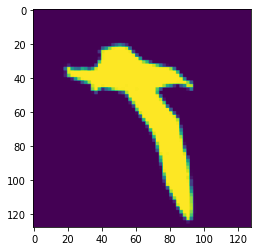

In [ ]:
plt.imshow(a[0,:,:,1])

In [ ]:
from skimage import img_as_ubyte

img = img_as_ubyte(x[11:12,:,:,:]) > 127

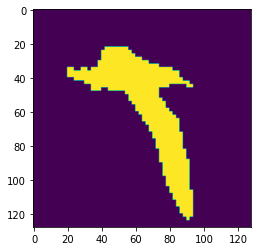

In [ ]:
plt.imshow(b[0,:,:,1])

In [ ]:
plt.imshow(y[0,:,:,1])

IndexError: ignored